# Maxwell's construction on van der Waals isotherms


**Code:** #111-000

**File:** `apps/van_der_waals/p_v_2D.ipynb`

**Run it online:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jongablop/MinervaLab/master?urlpath=%2Fnotebooks%2Fapps%2Fvan_der_waals%2Fp_v_2D.ipynb)

-----------

## Interface

The main interface (``main_block_111_000``) is divided in two Box: ``top_block_111_000`` and ``middle_block_111_000``.

``top_block_111_000`` contains the widgets to control the tenperatute range shown and the toggles of the different areas and isother types.

``middle_block_111_000`` contains the main figure (``fig_111_000``) and the different controlers to implement Maxwell's construction: ``T_slider`` changes the selected isotherm and ``p_slider`` controls the isobaric line.

Some buttons are only available if ``maxwell_construction_checkbox`` is activated.

``v_slider`` controls the position of the mark ``tracer`` and it is only available if ``show_tracer_checkbox`` is activated.

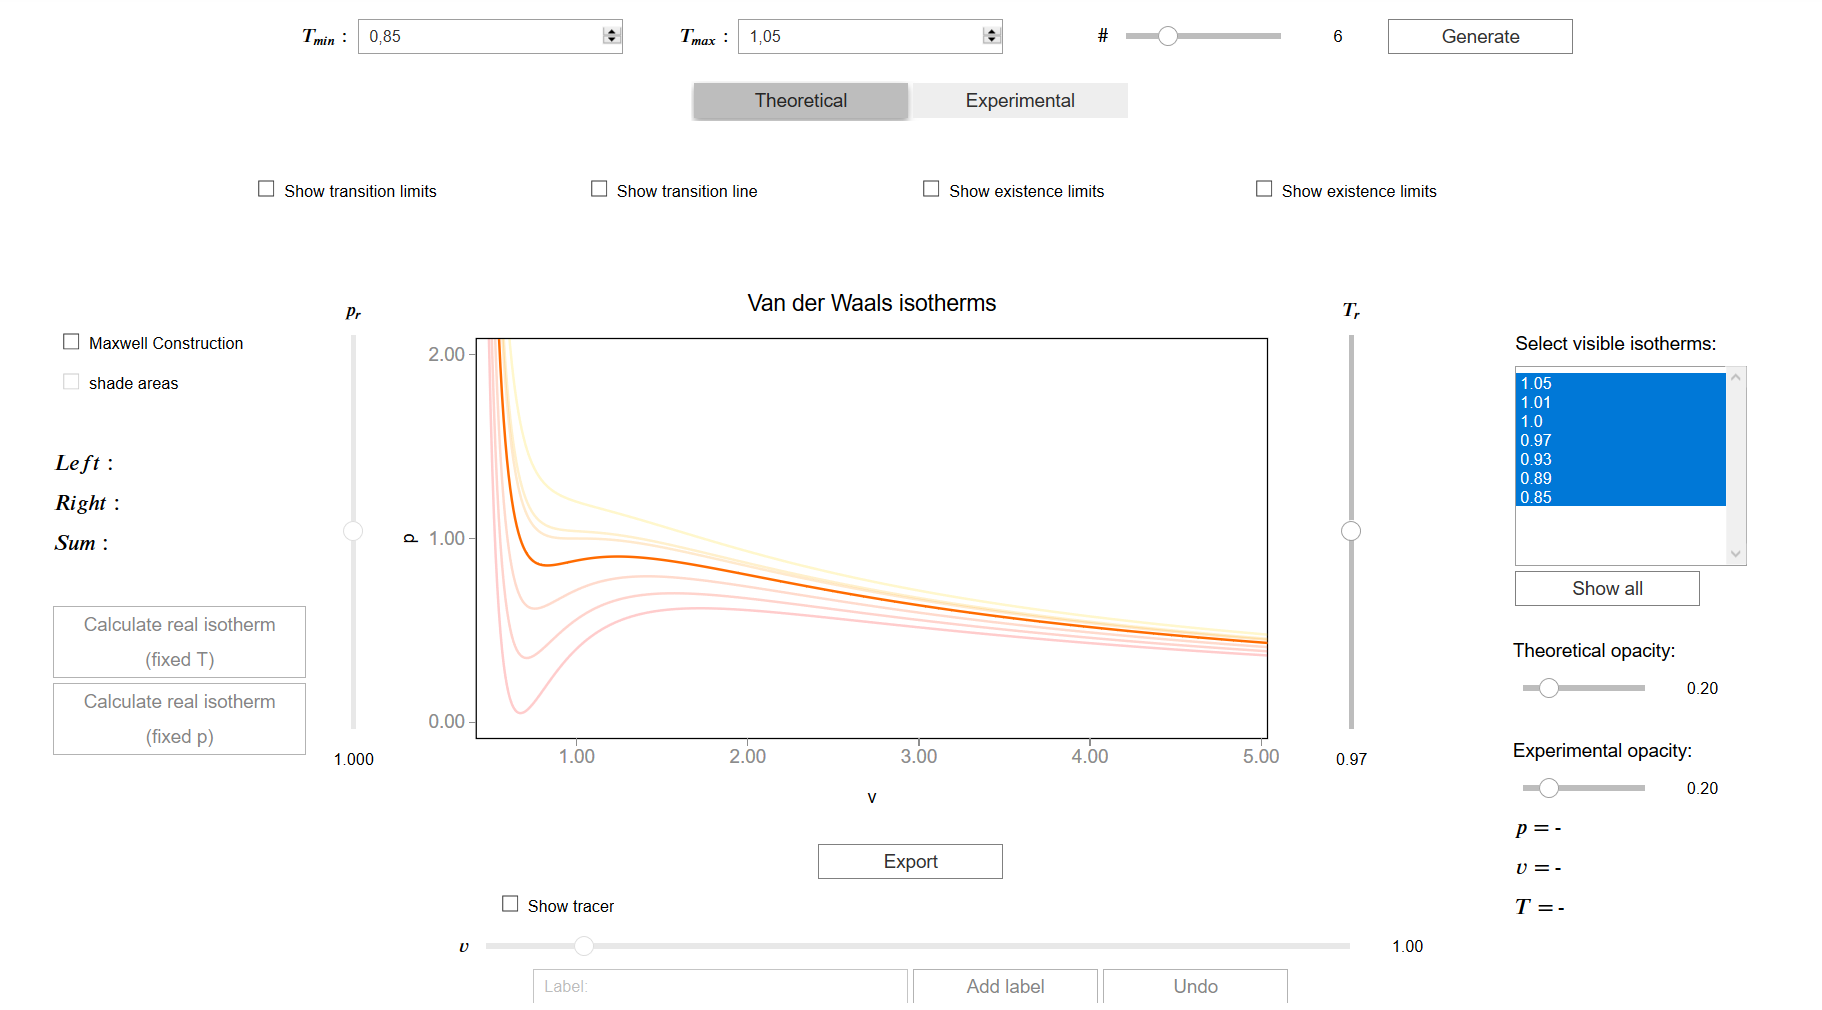

In [1]:
from IPython.display import Image
Image(filename='../../static/images/111-000_1.png')

## CSS

A custom `css` file is used to improve the interface of this application. It can be found [here](https://github.com/jongablop/MinervaLab/blob/master/static/custom.css).

In [2]:
from IPython.display import HTML
display(HTML("<head><link rel='stylesheet' type='text/css' href='./../../static/custom.css'></head>"))
display(HTML("<style>.container { width:100% !important; } .jupyter-button {white-space: normal !important;}</style>"))

## Packages

In [3]:
from bqplot import *
import bqplot as bq
import bqplot.marks as bqm
import bqplot.scales as bqs
import bqplot.axes as bqa

import ipywidgets as widgets

from scipy import interpolate
from scipy.signal import argrelextrema

import urllib.parse
import webbrowser

import sys

## Physical functions

This are the functions that have a physical meaning:

- `get_relative_isotherms`
- `experimetal_isotherms`
- `get_roots`
- `p_indefinite_integral`
- `p_definite_integral`
- `find_real_fixed_p`
- `find_real_fixed_T`

In [4]:
def get_relative_isotherms(v_range, T_range):
    """This function calculates the theoretical p(v, T) plane 
        (in reduced coordinates) according to van der Waals
        equation of state from a given range of volumes
        and tenperatures.

    Args:
        v_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated.\n
        T_range: An array containing the values of T
        (in reduced coordinates)for which the isotherms must be 
        calculated.\n

        
    Returns:
        isotherms: A list consisted of numpy arrays containing the
        pressures of each isotherm.
    """

    isotherms = []

    for T in T_range:
        p_R = []
        for v in v_range:
            val = (8.0/3.0*T/(v - 1.0/3.0) - 3.0/v**2)
            p_R = np.append(p_R, val)

        isotherms.append(p_R)

    return isotherms

In [5]:
def experimental_isotherms(p_range, v_range, T_range, fixed_p, fixed_T):
    """This function calculates the experimental p(v, T) plane 
        (in reduced coordinates) according to van der Waals
        equation of state for a given range of volumes
        and tenperatures or for a given range of volumes
        and pressures.

    Args:
        p_range: An array containing the values of p
        (in reduced coordinates)for which the isotherms must be 
        calculated. Only used if fixed_p == True.\n
        v_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated.\n
        T_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated. Only used if fixed_T == True.\n
        fixed_p: Boolean variable which represents if the isotherms 
        must be calculated for a given pressures.\n
        fixed_T: Boolean variable which represents if the isotherms 
        must be calculated for a given pressures.\n

        
    Returns:
        expe_data: A list consisted of numpy arrays containing the
        pressures of each theoretical isotherm.\n
        theo_data: A list consisted of numpy arrays containing the
        pressures of each theoretical isotherm.\n
        v_limits: A list consisted of arrays of the volume limits of
        the phase-transition of each subcritical isotherm.\n
        p_limits: A list consisted of arrays of the pressure limits of
        the phase-transition of each subcritical isotherm.\n
        tenperatures: A list consisted of the tenperatures of the
        isotherms.\n
    """
    
    if fixed_T:
    
        theo_data = get_relative_isotherms(v_range, T_range)
        expe_data = []

        v_limits = []
        p_limits = []

        p_range = np.linspace(0.001, 1.0, num=10000)
        pressures, v_isobaric_limits = find_real_fixed_T(p_range, T_range)

        for i in range(len(theo_data)):

            p_expe = []

            if i < len(v_isobaric_limits):

                    v_lim = v_isobaric_limits[i]

                    if len(v_lim) > 1: #check if there is only one point 
                        for j in range(len(v_range)):

                            if v_range[j] > v_lim[0] and v_range[j] < v_lim[1]:
                                p_expe.append(pressures[i])

                            else:
                                p_expe.append(theo_data[i][j])

                        v_limits = np.append(v_limits, [v_lim[0], v_lim[1]])
                        p_limits = np.append(p_limits, [pressures[i], pressures[i]])

                    else:
                        p_expe = theo_data[i]
                        v_limits = np.append(v_limits, [1.0])
                        p_limits = np.append(p_limits, [1.0])

            else:

                p_expe = theo_data[i]

            expe_data.append(p_expe)      

        tenperatures = T_range
        
        return expe_data, theo_data, p_limits, v_limits, tenperatures
    
    elif fixed_p:
        
        tenperatures, v_isobaric_limits = find_real_fixed_p(p_range, T_range)

        theo_data = get_relative_isotherms(v_range, tenperatures)
        expe_data = []

        v_limits = []
        p_limits = []
        
        for i in range(len(theo_data)):

            p_expe = []

            if i < len(v_isobaric_limits):

                    v_lim = v_isobaric_limits[i]

                    if len(v_lim) > 1: #check if there is only one point 
                        
                        for j in range(len(v_range)):

                            if v_range[j] > v_lim[0] and v_range[j] < v_lim[1]:
                                p_expe.append(p_range[i])

                            else:
                                p_expe.append(theo_data[i][j])

                        v_limits = np.append(
                            v_limits,
                            [v_lim[0],
                             v_lim[1]]
                        )
                        p_limits = np.append(
                            p_limits,
                            [p_range[i],
                             p_range[i]]
                        )

                    else:
                        p_expe = theo_data[i]
                        v_limits = np.append(v_limits, [1.0])
                        p_limits = np.append(p_limits, [1.0])

            else:

                p_expe = theo_data[i]

            expe_data.append(p_expe)      

        return expe_data, theo_data, p_limits, v_limits, tenperatures

In [6]:
def get_roots(p, T):
    """This function calculates the roots of a van der Waals
    isotherm of a given T and set of pressures.
    
    Args:
        p: Numpy array consisted of the pressures of the isotherm.\n
        T: Value of the tenperature.\n

    Returns:
        roots_in_range: A list consisted of the real roots.\n
    """
    
    
    roots = np.roots([1.0, - 1.0/3.0*(1.0 + 8.0*T/p), 3.0/p, -1.0/p])
    roots_in_range = []
    
    for root in roots:
        if np.isreal(root):
            root = np.real(root)
            if root > 0:
                roots_in_range.append(root)
    roots_in_range.sort()
    
    return roots_in_range

In [7]:
def p_indefinite_integral(p_0, v_0, T):
    """This function calculates the indefinite integral between
    a van der Waals isotherm and a isobaric line.
    
    Args:
        p0: Isobaric line's pressure.\n
        v0: Value of the volume.\n
        T: Value of the tenperature.\n

    Returns:
        integral: Value of the indefinite integral between a 
        van der Waals isotherm at T and a isobaric line of p0 at a
        volume v0.\n
    """
    
    integral = 8.0/3.0 * T *np.log(v_0 - 1.0/3.0) + 3.0/v_0 - p_0*v_0
    
    return integral

In [8]:
def definite_integral(p_0, v_range, T):
    """This function 'p_indefinite_integral' function to calculate
    the definite integral between a van der Waals isotherm and a
    isobaric line.
    
    Args:
        p0: Isobaric line's pressure.\n
        v_range: Tuple or list consisted of volume limits.\n
        T: Value of the tenperature.\n

    Returns:
        integral: Value of the definite integral between a 
        van der Waals isotherm at T and a isobaric line of p0 in a
        volume range v_range.\n
    """
    
    v_0, v_1 = v_range[0], v_range[1]
    
    integral = p_indefinite_integral(p_0, v_1, T) - p_indefinite_integral(p_0, v_0, T)
    
    return integral

In [9]:
def find_real_fixed_T(p_values, T_values):
    """This function uses Maxwell's construction to find the
       pressures in which phase transition happens given some
       fixed tenperatures.\n

    Args:
        p_values: List of pressures in which the real isotherm is
        searched.\n
        T_values: List of tenperatures of the isotherms.\n

        
    Returns:
        pressures: List of pressures in which phase transition
        happens.\n
        v_range: Volume limits of phase transition zones.
    """
    
    eps = 1e-3
    
    pressures = []
    v_ranges = []
    
    for T in T_values:
        
        if T < 1.0:
        
            for p in p_values:
                
                roots = get_roots(p, T)
                
                if len(roots) == 3:
                    
                    v_range = [roots[0], roots[2]]
                    area = definite_integral(p, v_range, T)
                    
                    if abs(area) < eps:
                        
                        pressures.append(p)
                        v_ranges.append(v_range)
                        
                        break
                        
        elif T == 1.0:
            
            pressures.append(1.0)
            v_ranges.append([1.0])

    return pressures, v_ranges

In [10]:
def find_real_fixed_p(p_values, T_values):
    """This function uses Maxwell's construction to find the
       tenperatures in which phase transition happens given some
       fixed pressures.\n

    Args:
        p_values: List of pressures of the isotherms.\n
        T_values: List of tenperatures in which the real isotherm is
        searched.\n 

        
    Returns:
        tenperatures: List of tenperatures in which phase transition
        happens.\n
        v_range: Volume limits of phase transition zones.
    """
    
    eps = 1e-3
    
    tenperatures = []
    v_ranges = []
    
    for p in p_values:
        
        if p < 1.0:
        
            for T in T_values:
                
                roots = get_roots(p, T)
                
                if len(roots) == 3:
                    
                    v_range = [roots[0], roots[2]]
                    area = definite_integral(p, v_range, T)
                    
                    if abs(area) < eps:
                        
                        tenperatures.append(T)
                        v_ranges.append(v_range)
                        
                        break
                        
        elif p == 1.0:
            
            tenperatures.append(1.0)
            v_ranges.append([1.0])

    return tenperatures, v_ranges

## Functions related to the interaction

In [11]:
def get_t_range(t_min_input, t_max_input, num_input):
    """This function calculates the set of N values between the
    values of the t_min_input and t_max_input widgets.
    
    Args:
        t_min_input: IPython widget which values represents the
        lower limit of the range.\n
        t_max_input:  IPython widget which values represents the
        upper limit of the range.\n
        num_input: IPython widget which values represents the
        number of values calculated.\n
        
    Returns:
        t_range: Numpy array containing the calculated values
        rounded to 3 decimals.
    """
    
    t_min = t_min_input.value
    t_max = t_max_input.value
    num = num_input.value
    
    t_range = []
    
    if t_min > t_max:
        t_range = np.linspace(start=t_max, stop=t_min, num=num)
    
    elif t_min == t_max:
        t_range = [t_min]

    else:
        t_range = np.linspace(start=t_min, stop=t_max, num=num)
        
    if 1.0 not in t_range:
        t_range = np.append(t_range, 1.0)
        t_range = np.sort(t_range)
    
    t_range = np.round(t_range, 3)
    
    return t_range

In [12]:
def find_nearest_index(array, value):
    """This function find index of the element in an array which
    value is the nearest to the given one.
    
    Args:
        array: A list or numpy array containing the elements.\n
        value: Float number.\n

    Returns:
        idx: Index of the element in array which value is the nearest
        to value.
    """
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [13]:
def show_tracer(change):
    """This function controls if the bqplot mark 'tracer' of
    the bqplot figure 'fig_111_000' is visible or not.\n
    """
    
    if show_tracer_checkbox.value:
        tracer.visible = True
        v_slider.disabled = False
        update_tracer(change)
        
        label_input.disabled = False
        add_label_button.disabled = False
        undo_label_button.disabled = False
        
    else:
        tracer.visible = False
        v_slider.disabled = True
        
        label_input.disabled = True
        add_label_button.disabled = True
        undo_label_button.disabled = True

In [14]:
def update_tracer(change):
    """This function updates the position of the bqplot mark 'tracer'
    of the bqplot figure 'fig_111_000' and the representation of the position
    of the tracer.\n
    """
    
    v = v_slider.value
    T = T_slider.value
    
    for mark in fig_111_000.marks:
        
        if str(T) in mark.labels:

            i = mark.labels.index(str(T))
            x_values = mark.x
            y_values = mark.y[i]
            
            break
    
    i_v = find_nearest_index(x_values, v)
    tracer.x = np.array([x_values[i_v]])
    tracer.y = np.array([y_values[i_v]])
    
    tracer_p.value = " " + str(np.round(tracer.y, 3)[0])
    tracer_v.value = " " + str(np.round(tracer.x, 3)[0])
    tracer_T.value = " " + str(T_slider.value)

In [15]:
def add_label(x, y, label):
    """This function adds a point and a name to the bqplot mark
    'labels_points' of the bqplot figure 'fig_111_000'.\n
    """
        
    x_labels = [elem for elem in labels_points.x]
    y_labels = [elem for elem in labels_points.y]
    
    x_labels.append(tracer.x[0])
    y_labels.append(tracer.y[0])
    
    labels_points.x, labels_points.y = x_labels, y_labels
    labels_points.names = np.append(labels_points.names, label)

In [16]:
def get_new_label(labels):
    """This function returns an alphabetical label different
    from the ones given in the 'labels' list.
    
    Args:
        labels: A list consisted of the current labels.\n

    Returns:
        elem: A string with a new label which is not in 'labels'.\n
    """
    
    
    alpha = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    alpha2 = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    count = 0
    i = 0
    while i < len(alpha):
        
        elem = alpha[i]
        
        if not np.isin(elem,labels):
            break
        
        if i == (len(alpha) - 1):
            alpha = [alpha2[count] + elem for elem in alpha2]
            i = 0
            count = count + 1
            
        i = i + 1
    
    return elem

In [17]:
def add_label_button_clicked(a):
    """This function is called when 'add_label_button' is clicked
    and calls 'add_label' function.\n
    """
    
    label = label_input.value
    
    if label == '':
        label = get_new_label(labels_points.names)
        
    add_label(tracer.x[0], tracer.y[0], label)
    label_input.value = ''

In [18]:
def undo_label_button_clicked(a):
    """This function removes the last label added to the bqplot
    mark 'labels_points' of the bqplot figure 'fig_111_000'.\n
    """
    
    if len(labels_points.x) > 0:
    
        labels_points.x, labels_points.y = labels_points.x[:-1], labels_points.y[:-1]
        labels_points.names = labels_points.names[:-1]

In [19]:
def update_isobaric(change):
    """This function updates the bqplot mark 'isobaric' of the bqplot figure
    'fig_111_000' when the slider 'p_slider' is moved. Also updates the value
    of the integrals.\n
    """    
    
    p = p_slider.value
    T = T_slider.value
    
    for mark in fig_111_000.marks:
        
        if str(T) in mark.labels:

            i = mark.labels.index(str(T))

            x_values = mark.x
            y_values = mark.y[i]
            break
        
    roots = get_roots(p, T)
    
    if len(roots) == 3:
        
        isobaric.fill = 'between'
        shade_areas(change)
        
        #find where the isobaric curve intersects the isotherm
        i_min = find_nearest_index(x_values, roots[0]) 
        i_max = find_nearest_index(x_values, roots[2])
        x_real = x_values.tolist()[i_min:i_max]
        
        #we have two lines: one for the isobaric and the other for the isotherm
        x = [x_real, x_real]
        y = [[p for elem in x_real], y_values[i_min:i_max]]
        
        v_range_1 = (roots[0], roots[1])
        v_range_2 = (roots[1], roots[2])

        left_integral = definite_integral(p, v_range_1, T)
        right_integral = definite_integral(p, v_range_2, T)
        
        integral_value_left_text.value = '%.2f' % left_integral
        integral_value_right_text.value = '%.2f' % right_integral
        
        integral_value_text.value = '%.2f' % (left_integral + right_integral)
        
    else:
        isobaric.fill = 'none'
        x = [x_values, x_values]
        y = [[p for elem in x_values], y_values]
        
        integral_value_left_text.value = '-'
        integral_value_right_text.value = '-'
        integral_value_text.value = '-'

    isobaric.x, isobaric.y = x, y

In [20]:
def shade_areas(change):
    """This function shades the area between the bqplot mark
    'isobaric' and the isotherm mark of the bqplot figure
    'fig_111_000'.\n
    """
    
    if shade_areas_checkbox.value:
        
        isobaric.fill_opacities = [0.35]
        
    else:
        
        isobaric.fill_opacities = [0.0]

In [21]:
def find_real_isotherm(a):
    """This function moves p_slider to find the real isotherm
    where both areas value is equal.\n
    """
    
    if T_slider.value < 1.0:
    
        p_min = p_slider.min
        p_max = 1.0
        step = p_slider.step

        p_range = np.arange(p_max, p_min, -step)

        for p in p_range:
            p_slider.value = p
            if integral_value_text.value == '0.00':
                break

In [22]:
def generate_isotherm_marks(p_range, v_range, T_range, fixed_T, fixed_p, scale_x, scale_y):
    """This function generates the marks of the experimental and
       theoretical isotherms (in reduced variables) and of the limits
       of the phase transition and the non-existence zones for a given
       range of volumes and tenperatures or for a given range of 
       volumes and pressures.

    Args:
        p_range: An array containing the values of p
        (in reduced coordinates)for which the isotherms must be 
        calculated. Only used if fixed_p == True.\n
        v_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated.\n
        T_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated. Only used if fixed_T == True.\n
        fixed_p: Boolean variable which represents if the isotherms 
        must be calculated for a given pressures.\n
        fixed_T: Boolean variable which represents if the isotherms 
        must be calculated for a given pressures.\n

        
    Returns:
        marks: The marks of the experimental and
        theoretical isotherms (in reduced variables) and of the limits
        of the phase transition and the non-existence zones.\n
        T_limits: A list consisted of the tenperatures of the
        isotherms.\n
    """    
    
    data = experimental_isotherms(
        p_range=p_range,
        v_range=v_range,
        T_range=T_range,
        fixed_T = fixed_T,
        fixed_p = fixed_p
    )

    expe_p_values = data[0]
    theo_p_values = data[1]
    
    p_limits = data[2]
    v_limits = data[3]
    T_limits = data[4]

    marks = []
    
    #generate a gradient from red to yellow
    colors = generate_gradient('#FF0000', '#FFfa00', len(T_limits)) 
    opacities = [opacity_theo_slider.value for t in T_limits]
    opacities[int(len(T_limits)/2)] = 1.0
    
    #theoretical isotherms
    marks.append(bqm.Lines(
        x = v_range, 
        y = np.array([theo_p_values]), 
        scales = {'x': scale_x, 'y': scale_y}, 
        opacities = opacities,
        visible = True, 
        colors = colors,
        labels = [str(t) for t in T_limits],
        name = 'theo'
        ))

    p_values_real = []
    v_values_real = []

    #experimental isotherms
    marks.append(bqm.Lines(
        x = v_range, 
        y = np.array([expe_p_values]), 
        scales = {'x': scale_x, 'y': scale_y}, 
        opacities = opacities,
        visible = experimental_toggle.value,
        colors = colors,
        labels = [str(t) for t in T_limits],
        line_style = 'solid'
        ))

    scatter_colors = []
    
    for color in colors:
        
        scatter_colors.append(color)
        scatter_colors.append(color)
    
    #maxwell limits
    marks.append(
        bqm.Scatter(
            x = v_limits,
            y = p_limits,
            scales = {'x': scale_x, 'y': scale_y}, 
            opacities = [opacity_theo_slider.value],
            visible = show_transition_limits_checkbox.value, 
            colors = ['blue'],
            names = [],
            labels = ['maxwell_limits'],
            default_size = 15,
            tooltip = tt
        )
    )
    
    try:
        
        # If there is only one point the interpolation
        # can't be done.
        
        f_maxwell = interpolate.interp1d(
            v_limits,
            p_limits,
            kind = 'cubic',
            fill_value = 'extrapolate'
        )

        maxwell_v = np.linspace(0.45, v_limits[1], 1000)
        maxwell_interp = f_maxwell(maxwell_v)

    except:
        
        maxwell_v = []
        maxwell_interp = []
        
   
    marks.append(bqm.Lines(
        x = maxwell_v, 
        y = maxwell_interp, 
        scales = {'x': scale_x, 'y': scale_y}, 
        opacities = [0.4],
        visible = show_transition_line_checkbox.value,
        colors = ['blue'],
        labels = ['maxwell_limits_interpolated'],
        line_style = 'solid',
        stroke_width = 3,
        fill = 'bottom',
        fill_opacities = [0.1]
        )
    )

    #non-existence limits
    non_e_min, non_e_max = find_local_extrema(theo_p_values)
    
    non_e_v_limits = []
    non_e_p_limits = []
    
    for i in range(len(non_e_min)):
        
        idx = non_e_min[i]
        non_e_p_limits = np.append(non_e_p_limits, np.take(theo_p_values[i],idx))
        non_e_v_limits = np.append(non_e_v_limits, np.take(v_range, idx))
        
    for i in range(len(non_e_max)):
        
        idx = non_e_max[i]
        non_e_p_limits = np.append(non_e_p_limits, np.take(theo_p_values[i],idx))
        non_e_v_limits = np.append(non_e_v_limits, np.take(v_range,idx))   
    
    non_e_p_limits = np.append(non_e_p_limits, 1.0)
    non_e_v_limits = np.append(non_e_v_limits, 1.0)
    
    marks.append(
        bqm.Scatter(
            x = non_e_v_limits,
            y = non_e_p_limits,
            scales = {'x': scale_x, 'y': scale_y}, 
            opacities = [opacity_expe_slider.value],
            visible = show_existence_limits_checkbox.value, 
            colors = ['green'], 
            names = [],
            labels = ['non-existence limits'],
            default_size = 15,
            tooltip = tt          
        )
    )
    
    try:
        
        # If there is only one point the interpolation
        # can't be done.
        
        f_non_e = interpolate.interp1d(
            non_e_v_limits,
            non_e_p_limits,
            kind='cubic'
        )
        
        
        
        non_e_v = np.linspace(min(non_e_v_limits), max(non_e_v_limits), 1000)
        non_e_interp = f_non_e(non_e_v)
        
    except:
        
        non_e_v = []
        non_e_interp = []
        
   
    marks.append(bqm.Lines(
        x = non_e_v, 
        y = non_e_interp, 
        scales = {'x': scale_x, 'y': scale_y}, 
        opacities = [0.4],
        visible = show_existence_line_checkbox.value,
        colors = ['green'],
        labels = ['non_existence_limits_interpolated'],
        line_style = 'solid',
        stroke_width = 3,
        fill = 'bottom',
        fill_opacities = [0.1]
        )
    )
    
    return marks, T_limits

In [23]:
def change_isotherms(a):
    """This function replaces the marks from the figure with
    the new calculated ones.
    """
    
    
    v_range = np.linspace(start=0.45, stop=5.2, num=500)
    t_range = get_t_range(t_min_input, t_max_input, num_input)
    
    marks, T_limits = generate_isotherm_marks(
        p_range=[],
        v_range=v_range,
        T_range=t_range,
        fixed_T=True,
        fixed_p=False,
        scale_x=scale_x,
        scale_y=scale_y
    )
    
    marks.append(tracer)
    marks.append(labels_points)
    marks.append(isobaric)
    
    fig_111_000.marks = marks

    T_slider.options = t_range
    
    select_visible.options = [str(t) for t in reversed(t_range)]
    select_visible.value = [str(t) for t in reversed(t_range)]

    
    T_slider.value=t_range[0]
    T_slider.value=t_range[int(t_range.size/2)]

In [24]:
def select_isotherm(change):
    """This function selects a isotherm from the figure using
    T_slider.
    """
    
    indexes = range(len(T_slider.options)-1, -1, -1)

    theo_opacities = [opacity_theo_slider.value for t in T_slider.options]
    expe_opacities = [opacity_expe_slider.value for t in T_slider.options] 

    if T_slider.index in indexes:
        
        if theoretical_toggle.value:
            
            theo_opacities[T_slider.index] = 1.0
            
        elif experimental_toggle.value:
            
            expe_opacities[T_slider.index] = 1.0
        
    for i in range(len(fig_111_000.marks)):
        
        mark = fig_111_000.marks[i]
        label = mark.labels[0]
        
        if str(T_slider.value) in mark.labels:
            
            if i%3 == 0 and label in select_visible.value:
               
                mark.opacities = theo_opacities
                
            elif i%3 == 1 and label in select_visible.value:
                
                mark.opacities = expe_opacities  
                
    if maxwell_construction_checkbox.value:
        
        update_isobaric(change)
        
    if show_tracer_checkbox.value:
        
        update_tracer(change)

In [25]:
def show_isotherm(change):
    """This function changes the visibility of the isotherms
    according to the ones which are selected in 'select_visible'.
    """
    
    indexes = []
    
    indexes = range(len(T_slider.options)-1, -1, -1)

    theo_opacities = [opacity_theo_slider.value for t in T_slider.options]
    expe_opacities = [opacity_expe_slider.value for t in T_slider.options]  
    
    if T_slider.index in indexes:
        
        if theoretical_toggle.value:
            
            theo_opacities[T_slider.index] = 1.0
            
        elif experimental_toggle.value:
            
            expe_opacities[T_slider.index] = 1.0
    #    opacities[T_slider.index] = 1.0 

    for i in range(len(fig_111_000.marks)):
        
        mark = fig_111_000.marks[i]
        label = mark.labels[0]
        
        if str(T_slider.value) in mark.labels:
            
            if i%3 == 0 and label in select_visible.value:
                
                mark.opacities = theo_opacities

            elif i%3 == 1 and label in select_visible.value:
                
                mark.opacities = expe_opacities
            
        elif label not in ('isobaric', 'labels', 'tracer'):

            if i%3 == 0 and label in select_visible.value:
                
                mark.visible = theoretical_toggle.value

            elif i%3 == 1 and label in select_visible.value:
                
                mark.visible = experimental_toggle.value

            elif i%3 == 2 and label in select_visible.value:
                
                mark.visible = show_limits_checkbox.value

In [26]:
def show_all(a):
    """This function makes all isotherms visible.
    """
    
    select_visible.value = [str(t) for t in T_slider.options]

In [27]:
def show_maxwell(change):
    """This function enables the buttons related to
    Maxwell's construction.
    """
    
    if maxwell_construction_checkbox.value:
        
        p_slider.disabled = False
        shade_areas_checkbox.disabled = False
        fixed_T_button.disabled = False
        fixed_p_button.disabled = False
        
        isobaric.visible = True
        update_isobaric(change)
        
    else:
        
        p_slider.disabled = True
        shade_areas_checkbox.disabled = True
        isobaric.visible = False
        fixed_T_button.disabled = True
        fixed_p_button.disabled = True

In [28]:
def show_limits(change):
    """This function controls the visibility of the limits
    of the phase transition and non-existence zones.
    """
    
    fig_111_000.marks[2].visible = show_transition_limits_checkbox.value
    fig_111_000.marks[3].visible = show_transition_line_checkbox.value
    fig_111_000.marks[4].visible = show_existence_limits_checkbox.value
    fig_111_000.marks[5].visible = show_existence_line_checkbox.value

In [29]:
def change_isotherm_type(change):
    """This function controls the visibility of the theoretical
    and experimental isotherms.
    """
    
    t_options = [str(t) for t in T_slider.options]
    
    for i in range(len(fig_111_000.marks)):
        
        mark = fig_111_000.marks[i]
        
        if i%3 == 0 and mark.labels[0] in select_visible.value:
            
            mark.visible = theoretical_toggle.value
            
        elif i%3 == 1 and mark.labels[0] in select_visible.value:
            
            mark.visible = experimental_toggle.value

In [30]:
def find_local_extrema(array):
    """This function fidn the local maxima and minima of a given
    array.

    Args:
        array: Numpy array containing the values.\n

        
    Returns:
        local_min_ind: List consisted of the indexes of the local
        minima.\n
        local_max_ind: List consisted of the indexes of the local
        maxima.\n
    """
    
    
    local_min_ind = []
    local_max_ind = []
    
    for a in array:
        
        local_min_ind.append(argrelextrema(a, np.less))
        local_max_ind.append(argrelextrema(a, np.greater))

    return local_min_ind, local_max_ind

In [31]:
def add_isotherm_mark_fixed_p(a):
    """This function adds a isotherm which real isotherm has a phase
    transition at pressure p to the figure.\n
    """    
    
    if p_slider.value < 1.0:
        
        v_values = np.linspace(start=0.45, stop=5.2, num=500)
        p_values = [p_slider.value]
        T_values = np.linspace(0.01, 1.0, 10000)

        new_marks, new_T_values = generate_isotherm_marks(
            p_range = p_values,
            v_range = v_values,
            T_range = T_values,
            fixed_T = False,
            fixed_p = True,
            scale_x = scale_x,
            scale_y = scale_y
        )
        
        #only take first three decimals
        new_T_values = [float(str(T)[:5]) for T in new_T_values]
        
        #calculate new tenperature range including new isotherms
        t_range = np.append(T_slider.options, new_T_values)
        new_t_range = np.sort(t_range)
        
        #get where the new marks should be inserted
        indexes, = np.where(new_t_range == new_T_values)
        
        #add data from the new isotherm to the old ones
        old_marks = fig_111_000.marks
        
        for i in range(2):

            try:
                old_marks[i].y = np.insert(
                    old_marks[i].y,
                    indexes,
                    new_marks[i].y,
                    axis=0
                )
            
            except:
                old_marks[i].y = np.insert(
                    old_marks[i].y,
                    indexes,
                    [new_marks[i].y],
                    axis=0
                )
            
            for label in new_marks[i].labels:
                new_labels = np.insert(
                    old_marks[i].labels,
                    indexes,
                    label
                )
                
            old_marks[i].labels = new_labels.tolist()

        for i in range(2, 4):

            old_marks[i].x = np.append(
                old_marks[i].x,
                new_marks[i].x,
                axis=0
            )
            
            old_marks[i].y = np.append(
                old_marks[i].y,
                new_marks[i].y,
                axis=0
            )
            
        #update colors
        colors = generate_gradient(
            '#FF0000',
            '#FFfa00',
            len(new_t_range)
        )
        
        old_marks[0].colors = colors
        old_marks[1].colors = colors
        
        fig_111_000.marks = old_marks
        
        #update tenperature slider and visible selector
        T_slider.options = new_t_range
        T_slider.value = new_t_range[0]

        T_slider.value = T_slider.options[indexes[0]]
        
        select_visible.options = [
            str(t) for t in T_slider.options[::-1]
        ]
        select_visible.value = [
            str(t) for t in T_slider.options[::-1]
        ]

In [32]:
def prepare_export(button):
    """This function sends the selected plot to the 'export_plot'
    function.
    """
    
    if button is prepare_export_fig_111_000_button:
        
        export_plot(fig_111_000)

In [33]:
def change_view(change):
    """This function changes the visualization of all the
    components of the application so they are suitable for
    a projection.\n
    """
    
    obj = change.owner

    if obj.value:
        
        obj.description = 'Presentation mode (ON)'
        
        display(HTML(
            "<style>" \
            ".widget-readout { font-size: 30px ; }" \
            ".widget-label-basic {font-size: 30px;}" \
            "option {font-size: 25px;}" \
            ".p-Widget.jupyter-widgets.widget-slider.widget-vslider.widget-inline-vbox {width: auto}" \
            ".p-Widget .jupyter-widgets .widgets-label {width: auto; height: auto; font-size: 30px;}" \
            ".widget-label {font-size: 30px ; height: auto !important;}" \
            ".p-Widget .bqplot .figure .jupyter-widgets {height: auto !important;}" \
            ".widget-text input[type='number'] {font-size: 30px;height: auto;}" \
            ".option { font-size: 30px ;}" \
            ".p-Widget .jupyter-widgets .jupyter-button.widget-button {font-size: 30px ; width: auto; height: auto;}" \
            ".p-Widget.jupyter-widgets.jupyter-button.widget-toggle-button{font-size: 30px ; width: auto; height: auto;}" \
            ".p-Widget.p-Panel.jupyter-widgets.widget-container.widget-box.widget-vbox {padding-bottom: 30px}" \
            ".bqplot > svg .axis text.axislabel, .bqplot > svg .axis tspan.axislabel {font-size: 30px;}"
            "</style>"
            )
        )

        for figure in figures:
            
            figure.legend_text = {'font-size': '30px'}
            figure.title_style = {'font-size': '30px'}

            for axis in figure.axes:
                axis.tick_style = {'font-size': '30px'}
                axis.label_style = {'font-size': '30px'}
        
    else:
        
        obj.description = 'Presentation mode (OFF)'
        
        display(HTML(
            "<style>" \
            ".widget-readout { font-size: 14px ;}" \
            ".widget-label-basic {font-size: 14px;}" \
            "option {font-size: 12px;}" \
            ".p-Widget .jupyter-widgets .widgets-label {font-size: 14px;}" \
            ".widget-label {font-size: 14px ;}" \
            ".widget-text input[type='number'] {font-size: 14px;}" \
            ".option { font-size: 14px ;}" \
            ".p-Widget .jupyter-widgets .jupyter-button.widget-button {font-size: 14px;}" \
            ".p-Widget.jupyter-widgets.jupyter-button.widget-toggle-button {font-size: 14px;}" \
            ".bqplot > svg .axis text.axislabel, .bqplot > svg .axis tspan.axislabel {font-size: 14px;}"
            "</style>"
            )
        )
        
        for figure in figures:
            
            figure.legend_text = {'font-size': '14px'}
            figure.title_style = {'font-size': '20px'}

            for axis in figure.axes:
                axis.tick_style = {'font-size': '14px'}
                axis.label_style = {'font-size': '14px'}

In [34]:
def export_plot(plot):
    """This function sends the selected plot to the export module.
    """
    
    global data
    
    text_lines = []
    
    np.set_printoptions(threshold=sys.maxsize)
    data =  repr((plot, text_lines))
    
    %store data
    
    rel_url = "../../../apps/modules/export_module.ipynb"
    abs_url = urllib.parse.urljoin(notebook_url, rel_url)

    if not webbrowser.open(abs_url):
        go_to_export_button.value = "<form action=" + abs_url + " target='_blank'><button type=''submit''>Open in export module</button></form>"

In [35]:
%%javascript 

//Get the URL of the current notebook

var kernel = Jupyter.notebook.kernel; 
var command = ["notebook_url = ",
               "'", window.location.href, "'" ].join('')

kernel.execute(command)

<IPython.core.display.Javascript object>

## Functions related to visualization

In [36]:
def hex_to_rgb(number_hex):
    """This function converts a hexadecimal color to its rgb
    equivalent.
    
    Args:
        number_hex: String containing the hexadecimal representation
        of the color.\n
        
    Returns:
        number_rgb: Tuple consisted of the 3 numbers of the rgb
        representation of the color.\n
    """
    
    if '#' in number_hex:
        number_hex = number_hex[1:]
    
    number_rgb = (int(number_hex[0:2], 16), \
                  int(number_hex[2:4], 16), \
                  int(number_hex[4:], 16))
    
    return number_rgb

In [37]:
def rgb_to_hex(number_rgb):
    """This function converts a rgb color to its hexadecimal
    equivalent.
    
    Args:
        number_rgb: Tuple consisted of the 3 numbers of the rgb
        representation of the color.\n
        
    Returns:
        number_hex: String containing the hexadecimal representation
        of the color.\n
    """
    
    number_rgb = '#' \
    + format(number_rgb[0], '02x') \
    + format(number_rgb[1], '02x') \
    + format(number_rgb[2], '02x')
    
    return number_rgb

In [38]:
def generate_gradient(initial, final, length):
    """This function generates a color gradient consisted of N
    colors from the initial to the final.
    
    Args:
        initial: String of the hexadecimal representation of the
        initial color.\n
        final: String of the hexadecimal representation of the
        final color.\n
        length: Number of colors.\n
        
    Returns:
        colors: List consisted of strings of the hexadecimal
        colors.\n
    """
    
    i_r, i_g, i_b = hex_to_rgb(initial)
    f_r, f_g, f_b = hex_to_rgb(final)
    
    r_step = (f_r - i_r)/length
    g_step = (f_g - i_g)/length
    b_step = (f_b - i_b)/length
    
    r, g, b = i_r, i_g, i_b
    colors = []
    
    for i in range(length):

        h = rgb_to_hex((int(round(r)),int(round(g)),int(round(b))))
        
        colors.append(h)
        
        r = r + r_step
        g = g + g_step
        b = b + b_step

    return colors

## Main interface

In [ ]:
"""

.. module:: p_v_2D.ipynb
    :sypnopsis: This module creates an interface to interact with the
    van der Waals isotherms in the p(v, T) plane.\n

.. moduleauthor:: Jon Gabirondo López (jgabirondo001@ikasle.ehu.eus)

"""

saved = []

#############################
######TOP BLOCK##############
#############################

top_block_111_000 = widgets.VBox(
    [],
    layout=widgets.Layout(align_items='center')
)

change_view_button = widgets.ToggleButton(
    value=False,
    description='Presentation mode (OFF)',
    disabled=False,
    button_style='',
    tooltip='',
    icon='desktop',
    layout=widgets.Layout(
        width='auto'
    )
)

change_view_button.observe(change_view, 'value')

t_min_input = widgets.BoundedFloatText(
    value=0.85,
    min=0.5,
    max=3.0,
    step=0.005,
    description=r'\( T_{min}: \)',
    disabled=False
)

t_max_input = widgets.BoundedFloatText(
    value=1.05,
    min=0.5,
    max=3.0,
    step=0.005,
    description=r'\( T_{max}: \)',
    disabled=False
)

num_input = widgets.IntSlider(
    value=6,
    min=1,
    max=20,
    description=r'\( \# \)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
)

generate_button = widgets.Button(
    description='Generate',
    disabled=False,
    button_style='',
    tooltip='Generate isotherms in the selected T range.',
)

generate_button.on_click(change_isotherms)

#############################
#isotherm_type_block
#############################

theoretical_toggle = widgets.ToggleButton(
    value=True,
    description='Theoretical',
    disabled=False,
    button_style='',
    tooltip='Show theoretical isotherms',
    style = {'description_width': 'initial'},
    layout = widgets.Layout(
        align_self='center',
        width='100%'
    )
)

experimental_toggle = widgets.ToggleButton(
    value=False,
    description='Experimental',
    disabled=False,
    button_style='',
    tooltip='Show experimental isotherms',
    style = {'description_width': 'initial'},
    layout = widgets.Layout(
        align_self='center',
        width='100%'
    ),
)

theoretical_toggle.observe(change_isotherm_type, 'value')
experimental_toggle.observe(change_isotherm_type, 'value')

show_transition_limits_checkbox = widgets.Checkbox(
    value=False,
    description='Show transition limits',
    disabled=False,
    layout = widgets.Layout(width='148px !important')
)

show_transition_line_checkbox = widgets.Checkbox(
    value=False,
    description='Show transition line',
    disabled=False,
    layout = widgets.Layout(width='148px !important')
)

show_existence_limits_checkbox = widgets.Checkbox(
    value=False,
    description='Show existence limits',
    disabled=False,
    layout = widgets.Layout(width='148px !important')
)

show_existence_line_checkbox = widgets.Checkbox(
    value=False,
    description='Show existence limits',
    disabled=False,
    layout = widgets.Layout(width='148px !important')
)

show_transition_limits_checkbox.observe(show_limits, 'value')
show_transition_line_checkbox.observe(show_limits, 'value')
show_existence_limits_checkbox.observe(show_limits, 'value')
show_existence_line_checkbox.observe(show_limits, 'value')

isotherm_type_block = widgets.HBox(
    [],
    layout = widgets.Layout(
        align_self='center',
        margin='10px 0 0 0'
    )
)

top_block_111_000.children = [
    change_view_button,
    widgets.HTML('</br>'),
    widgets.HBox([
        t_min_input,
        t_max_input,
        num_input,
        generate_button
    ]),
    widgets.HBox([
        theoretical_toggle,
        experimental_toggle,
    ],
        layout = widgets.Layout(
            margin='20px 0 20px 0',
            width='33%')
    ),
    widgets.HBox([
        show_transition_limits_checkbox,
        show_transition_line_checkbox,
        show_existence_limits_checkbox,
        show_existence_line_checkbox
    ],
        layout = widgets.Layout(
            margin='20px 0 20px 0',
            width='100%')
    )
]

#############################
############MIDDLE BLOCK#####
#############################

middle_block_111_000 = widgets.HBox(
    [],
    layout=widgets.Layout(width='100%')
)

T_values = get_t_range(t_min_input, t_max_input, num_input)

############################
#FIGURE
############################

scale_x = bqs.LinearScale(min = 0.45, max = 5.0)
scale_y = bqs.LinearScale(min = 0.0, max = 2.0)

fig_111_000 = bq.Figure(
    title='Van der Waals isotherms',
    marks=[],
    axes=[],
    animation_duration=0,
    layout = widgets.Layout(
        align_self='center',
        width='75%'
    ),
    legend_location='top-right',
    background_style= {'fill': 'white','stroke': 'black'},
    fig_margin=dict(top=80,bottom=80,left=60,right=30),
    toolbar = True
    )

axis_x = bqa.Axis(
    scale=scale_x,
    tick_format='0.2f',
    tick_style={'font-size': '15px'},
    tick_values=[1.0, 2.0, 3.0, 4.0, 5.0],
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    label='v',
    label_location='middle',
    label_style={'stroke': 'black', 'default-size': 35},
    label_offset='50px'
)

axis_y = bqa.Axis(
    scale=scale_y,
    tick_format='0.2f',
    tick_style={'font-size': '15px'},
    tick_values=[0.0, 1.0, 2.0],
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    orientation='vertical',
    label='p',
    label_location='middle',
    label_style={'stroke': 'red', 'default_size': 35},
    label_offset='50px'
)

fig_111_000.axes = [axis_x, axis_y]


tt = bq.Tooltip(
    fields = ['y', 'x'],
    formats = ['.3f', '.3f'],
    labels = ['p', 'v']
)

marks = []

tracer = bqm.Scatter(
    name = 'tracer',
    x = [1.0],
    y = [1.0],
    scales = {'x': scale_x, 'y': scale_y}, 
    visible = False,
    colors = ['black'],
    names = [],
    labels=['tracer'],
    tooltip = tt
)        

marks.append(tracer)

labels_points = bqm.Scatter(
    name = 'labels',
    x = [],
    y = [],
    scales = {'x': scale_x, 'y': scale_y}, 
    #opacities = [1.0],
    visible = True,
    colors = ['black'],
    names = [],
    labels=['labels'],
    tooltip = tt,
) 

marks.append(labels_points)


isobaric = bqm.Lines(
    x = [], 
    y = [], 
    scales = {'x': scale_x, 'y': scale_y}, 
    opacities = [1.0, 0.0],
    visible = False,
    colors = ['green'],
    fill_opacities = [0.35],
    fill = 'none',
    labels = ['isobaric'],
)

marks.append(isobaric)

################################
#LEFT BLOCK
################################

left_block_111_000 = widgets.VBox(
    [],
    layout = widgets.Layout(
        width='15%',
        margin = '70px 0 0 0'
    )
)

maxwell_construction_checkbox = widgets.Checkbox(
    value=False,
    description='Maxwell Construction',
    disabled=False
)

maxwell_construction_checkbox.observe(show_maxwell, 'value')

p_slider = widgets.FloatSlider(
    value=1.0,
    min=0.001,
    max=scale_y.max,
    step=0.001,
    description=r'\( p_r \)',
    disabled=True,
    continuous_update=True,
    orientation='vertical',
    readout=True,
    readout_format='.3f',
    layout = widgets.Layout(
        height = '80%',
        margin = '45px 0 0 0'
    )
)

p_slider.observe(update_isobaric, 'value')

shade_areas_checkbox = widgets.Checkbox(
    value=False,
    description='shade areas',
    disabled=True
)

shade_areas_checkbox.observe(shade_areas, 'value')

integral_value_text = widgets.HTML(
    value="",
)

integral_value_left_text = widgets.HTML(
    value="",
) 

integral_value_right_text = widgets.HTML(
    value="",
) 

fixed_T_button = widgets.Button(
    description='Calculate real isotherm (fixed T)',
    disabled=True,
    button_style='',
    tooltip="Use Maxwell's construction to" \
            "calculate real isotherm (fixed T)",
    layout = {
        'width' : 'auto',
        'height' : 'auto',
    }
)

fixed_T_button.on_click(find_real_isotherm)

fixed_p_button = widgets.Button(
    description='Calculate real isotherm (fixed p)',
    disabled=True,
    button_style='',
    tooltip="Use Maxwell's construction to" \
            "calculate real isotherm (fixed p)",
    layout = {
        'width' : 'auto',
        'height' : 'auto',
    }
)

fixed_p_button.on_click(add_isotherm_mark_fixed_p)

left_block_111_000.children = [
    maxwell_construction_checkbox,
    shade_areas_checkbox,
    widgets.HTML(value="</br>"),
    widgets.HBox([
        widgets.Label(value="$Left:$"),
        integral_value_left_text,
    ]),
    widgets.HBox([
        widgets.Label(value="$Right:$"),
        integral_value_right_text,
    ]),
    widgets.HBox([
        widgets.Label(value="$Sum:$"),
        integral_value_text,
    ]),
    widgets.HTML(value="</br>"),
    fixed_T_button,
    fixed_p_button
]

################################
#RIGHT BLOCK
################################

right_block_111_000 = widgets.VBox(
    [],
    layout = widgets.Layout(
        width='15%',
        margin = '70px 0 0 0'
    )
)

T_slider = widgets.SelectionSlider(
    options=T_values,
    value=T_values[int(T_values.size/2)],
    description=r'\( T_r \)',
    disabled=False,
    continuous_update=True,
    orientation='vertical',
    readout=True,
    layout = widgets.Layout(
        height = '80%',
        margin = '45px 0 0 0'
    )
)

T_slider.observe(select_isotherm, 'value')

select_visible = widgets.SelectMultiple(
    options=[str(t) for t in T_values],
    value=[str(t) for t in T_values],
    rows=10,
    description='',
    disabled=False,
    layout = widgets.Layout(width = '90%')
)

select_visible.observe(show_isotherm, 'value')

show_all_button = widgets.Button(
    description='Show all',
    disabled=False,
    button_style='',
    tooltip='Show all isotherms',
)

show_all_button.on_click(show_all)

opacity_theo_slider = widgets.FloatSlider(
    value=0.2,
    min=0.0,
    max=1.0,
    step=0.05,
    description="",
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    layout = widgets.Layout(width = '90%')
)

opacity_theo_slider.observe(select_isotherm, 'value')

opacity_expe_slider = widgets.FloatSlider(
    value=0.2,
    min=0.0,
    max=1.0,
    step=0.05,
    description="",
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    layout = widgets.Layout(width = '90%')
)

opacity_expe_slider.observe(select_isotherm, 'value')

tracer_p = widgets.Label(value=" - ")
tracer_p_base = widgets.Label(value="$p =$")

tracer_v = widgets.Label(value=" - ")
tracer_v_base = widgets.Label(value="$v =$")

tracer_T = widgets.Label(value=" - ")
tracer_T_base = widgets.Label(value="$T =$")

right_block_111_000.children = [
    widgets.Label(value="Select visible isotherms:"),
    select_visible,
    show_all_button,
    widgets.Label(
        value="Theoretical opacity:",
        layout=widgets.Layout(
            margin='20px 0 0 0'
        )
    ),
    opacity_theo_slider,
    widgets.Label(
        value="Experimental opacity:",
        layout=widgets.Layout(
            margin='20px 0 0 0'
        )
    ),
    opacity_expe_slider,
    widgets.HBox([
        tracer_p_base,
        tracer_p,
    ]),
    widgets.HBox([
        tracer_v_base,
        tracer_v,
    ]),
    widgets.HBox([
        tracer_T_base,
        tracer_T,
    ]),
]

################################
#tracer_block
################################

tracer_block_111_000 = widgets.VBox(
    [],
    layout=widgets.Layout(
        align_items="center",
        width="100%"
    )
)

show_tracer_checkbox = widgets.Checkbox(
    value=False,
    description='Show tracer',
    disabled=False,
    layout=widgets.Layout(width='40%')
)

show_tracer_checkbox.observe(show_tracer, 'value')


v_slider = widgets.FloatSlider(
    value=1.0,
    min=0.5,
    max=5.0,
    step=0.001,
    description=r'\( v \)',
    disabled=True,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout = widgets.Layout(width = '90%')
)

v_slider.observe(update_tracer, 'value')

label_input = widgets.Text(
    value='',
    placeholder="Label:",
    disabled = True,
)

add_label_button = widgets.Button(
        description='Add label',
        disabled=True,
        button_style='',
        tooltip="Add label in tracer's position",
    )

add_label_button.on_click(add_label_button_clicked)

undo_label_button = widgets.Button(
        description='Undo',
        disabled=True,
        button_style='', 
        tooltip="Remove last added label",
    )

undo_label_button.on_click(undo_label_button_clicked)

tracer_block_111_000.children = [
    widgets.HBox([
        show_tracer_checkbox,
    ],
        layout=widgets.Layout(
            align_items="center",
            width="70%")
    ),
    v_slider,
    widgets.HBox([
        label_input,
        add_label_button,
        undo_label_button
    ],
        layout=widgets.Layout(
            align_items="center"
        )
    )
]

#############################
#FIGURE BLOCK
#############################
change_isotherms(None)

figure_block_111_000 = widgets.VBox(
    [],
    layout = widgets.Layout(width='70%')
)

prepare_export_fig_111_000_button = widgets.Button(
        description='Export',
        disabled=False,
        button_style='',
        tooltip='',
    )

prepare_export_fig_111_000_button.on_click(prepare_export)

go_to_export_button = widgets.HTML()

figure_block_111_000.children = [
    widgets.HBox([
        p_slider,
        fig_111_000,
        T_slider
    ]),
    widgets.VBox([
        prepare_export_fig_111_000_button,
        go_to_export_button
        ],
        layout=widgets.Layout(
            align_items="center",
            width="100%"
        )
    ),
    tracer_block_111_000
]

middle_block_111_000.children = [
    left_block_111_000,
    figure_block_111_000,
    right_block_111_000
]

############################
########MAIN BLOCK##########
############################

main_block_111_000 = widgets.VBox(
    [],
    layout=widgets.Layout(
        width='100%',
        align_items='center'
    )
)


main_block_111_000.children = [
    top_block_111_000,
    middle_block_111_000,
]

figures = [
    fig_111_000
]

main_block_111_000